In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   
# from custom_classes_defs.fnet import *
# from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247
BATCH_SIZE = 64
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

# import keras_tuner as kt
# -------------------------------------------------------

2024-04-24 21:20:00.089002: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 21:20:01.067833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 21:20:01.068224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 21:20:01.210948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 21:20:01.499126: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Wed Apr 24 21:20:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0              34W / 250W |    597MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0   N/A  N/A    948201      C   ...onda/envs/detectron2-env/bin/python      584MiB |
+---------------------------------------------------------------------------------------+


In [6]:
pets = Oxford_Pets(
        input_dir = "./data/images/",
        target_dir = "./data/annotations/trimaps/",
        img_size = (160, 160),
        batch_size = BATCH_SIZE
    )

train_dataset, valid_dataset, test_dataset = \
        pets.split_data(train_ratio=0.5, val_ratio=0.2, seed=RND_STATE)

print(f"training data (size = {len(train_dataset)*BATCH_SIZE})")
print(f"validation data (size = {len(valid_dataset)*BATCH_SIZE})")
print(f"test data (size = {len(test_dataset)*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])


Number of samples: 7390


2024-04-24 21:20:46.961790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37785 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


training data (size = 3712)
validation data (size = 1536)
test data (size = 2240)
Data images tensor: TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None)


In [7]:

# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=0,
    save_path='./models/unet',
    img_shape=pets.img_size,
    target_size=pets.img_size,
    channels_dim=(3,3),
    pos_label=0,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1)
)


callbacks=conf.callbacks()
conf.set( validation_data=valid_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.legacy.Adam(1e-4), 
    loss="sparse_categorical_crossentropy",
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

        compile_args:
                     optimizer: <class 'keras.src.optimizers.legacy.adam.Adam'>
                          loss: sparse_categorical_crossentropy
                       metrics: accuracy
       training_args:
                        epochs: 100
                    batch_size: 64
                       shuffle: False
                       verbose: 0
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <keras.src.callbacks.ReduceLROnPlateau object at 0x7f3afe874b50>
                              : <keras.src.callbacks.ModelCheckpoint object at 0x7f3b37dea0d0>
                              : <keras.src.callbacks.EarlyStopping object at 0x7f3afe9ec610>
          model_arch:
                     img_shape: (160, 160)
                   target_size: (160, 160)
                  channels_dim: (3, 3)
                       scaling: 255.0
                  augmentation: False
new_training_session: True
 

### Build model

In [8]:
### SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING
## François Chollet. Deep Learning with Python, Second Edition (Kindle Location 12675). Manning Publications Co.. 
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

# model.summary()
plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Total number of parameters: 2,058,979
Total trainable wieghts: 2,055,203
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


2024-04-24 21:21:04.404794: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 28: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 33: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 40: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 45: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 51: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 56: ReduceLROnPlateau reducing learning rate to 1e-06.


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


training elapsed time: ___7.06 ___ minutes
...training completed!


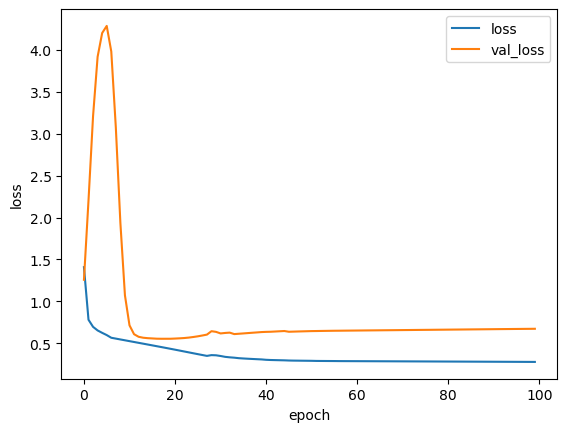

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


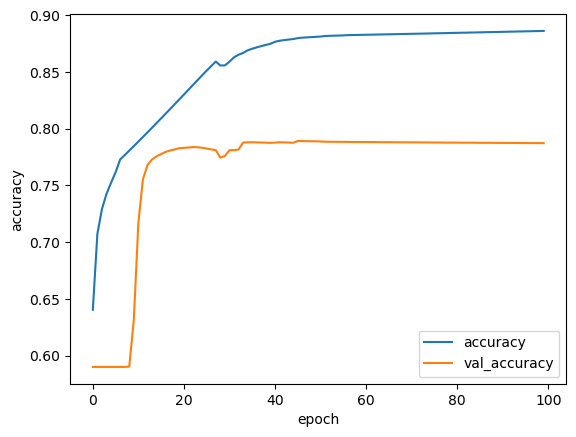

In [10]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

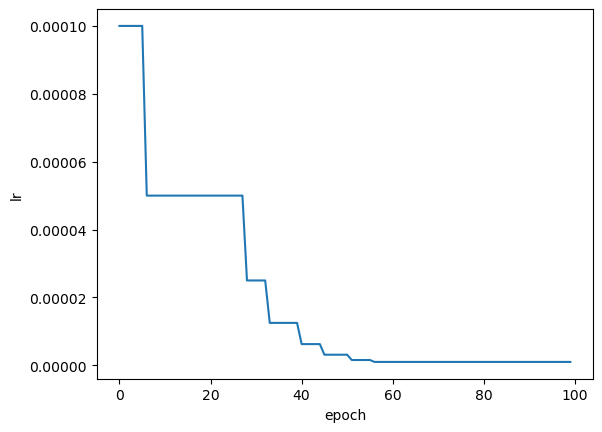

In [11]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

In [12]:
# Generate predictions for all images in the validation set
y_preds = model.predict(test_dataset)


 1/35 [..............................] - ETA: 21s

 2/35 [>.............................] - ETA: 2s 

 3/35 [=>............................] - ETA: 2s

 4/35 [==>...........................] - ETA: 2s

 5/35 [===>..........................] - ETA: 2s

 6/35 [====>.........................] - ETA: 2s

 7/35 [=====>........................] - ETA: 2s

 8/35 [=====>........................] - ETA: 2s

 9/35 [======>.......................] - ETA: 2s

10/35 [=======>......................] - ETA: 2s

11/35 [========>.....................] - ETA: 1s

12/35 [=========>....................] - ETA: 1s

13/35 [==========>...................] - ETA: 1s

14/35 [===========>..................] - ETA: 1s

15/35 [===========>..................] - ETA: 1s

16/35 [============>.................] - ETA: 1s

17/35 [=============>................] - ETA: 1s

18/35 [==============>...............] - ETA: 1s

19/35 [===============>..............] - ETA: 1s

20/35 [================>.............] - ETA: 1s

21/35 [=================>............] - ETA: 1s

22/35 [=================>............] - ETA: 0s

23/35 [==================>...........] - ETA: 0s

24/35 [===================>..........] - ETA: 0s

25/35 [====================>.........] - ETA: 0s

26/35 [=====================>........] - ETA: 0s

27/35 [======================>.......] - ETA: 0s

28/35 [=======================>......] - ETA: 0s

29/35 [=======================>......] - ETA: 0s

31/35 [=========================>....] - ETA: 0s

33/35 [===========================>..] - ETA: 0s

34/35 [============================>.] - ETA: 0s

35/35 [==============================] - ETA: 0s

35/35 [==============================] - 4s 98ms/step


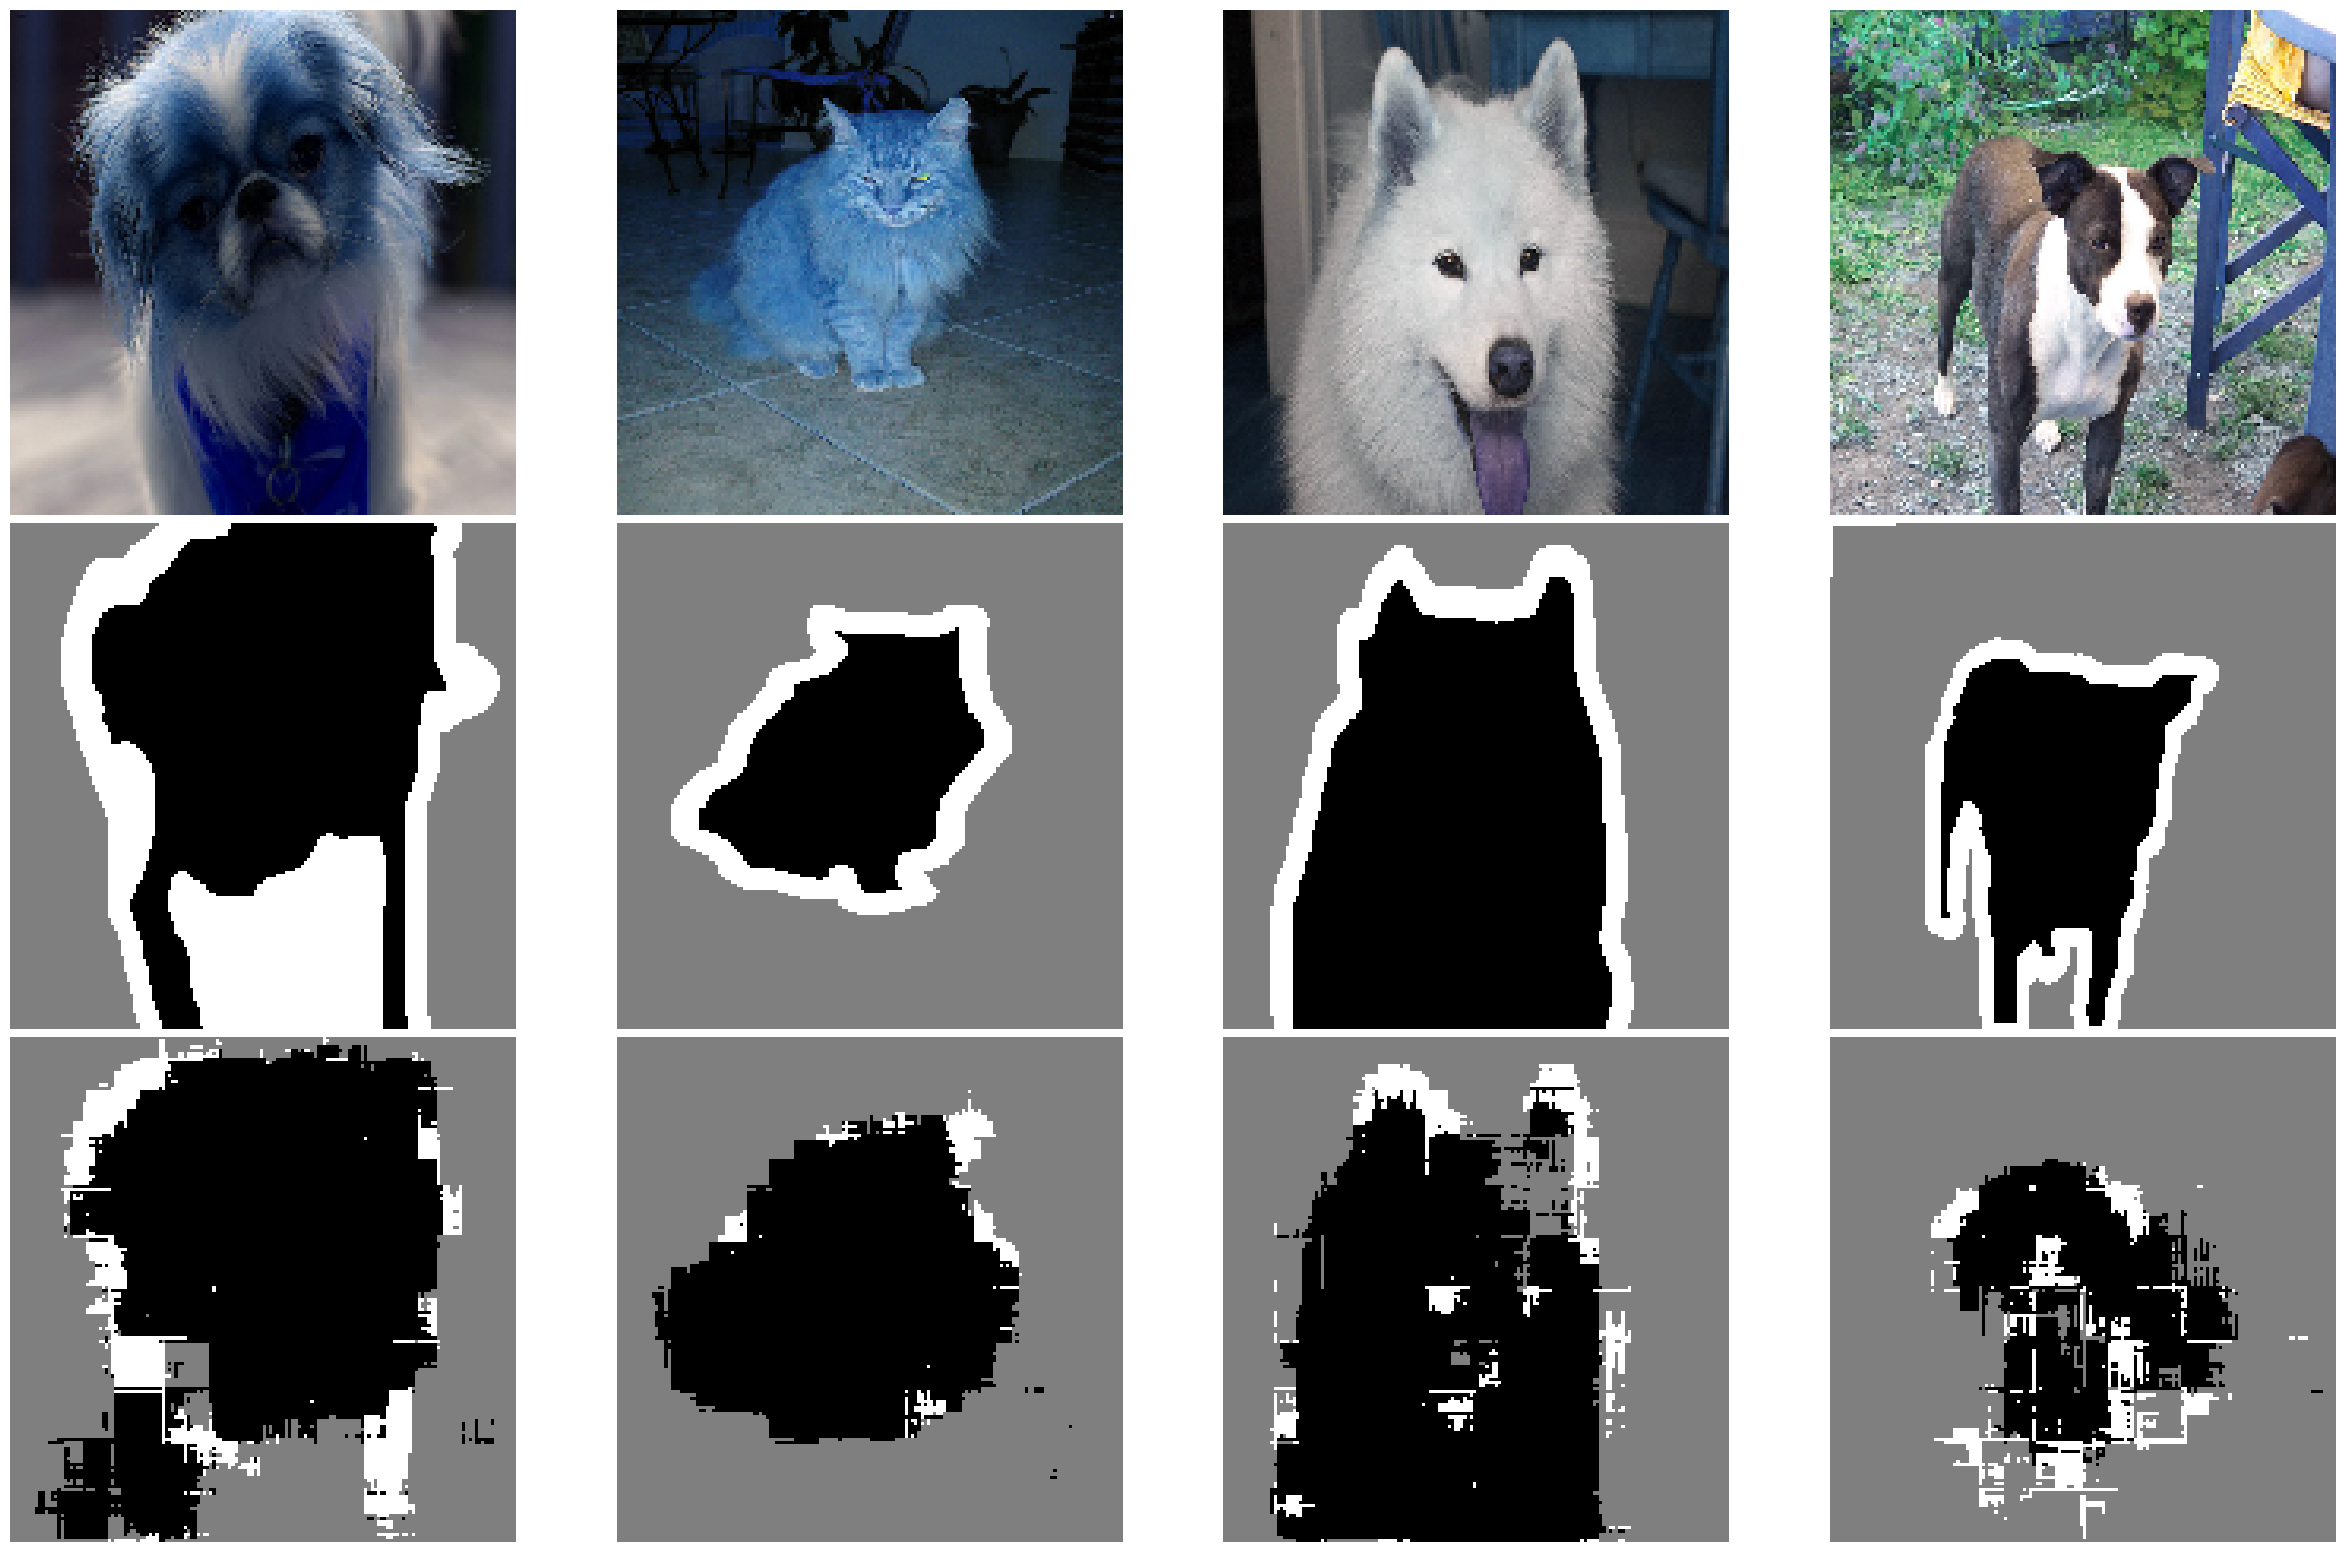

In [13]:
if INTERACTIVE_SESSION:
    pets.display_sample_image(y_preds, 'test')


In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))

model.evaluate(x=test_dataset)




	Evaluate unet model
-------------------------------------------------------
 1/35 [..............................] - ETA: 3s - loss: 0.6293 - accuracy: 0.7574

 3/35 [=>............................] - ETA: 1s - loss: 0.5971 - accuracy: 0.7676

 5/35 [===>..........................] - ETA: 1s - loss: 0.5851 - accuracy: 0.7737

 7/35 [=====>........................] - ETA: 1s - loss: 0.5796 - accuracy: 0.7754

 9/35 [======>.......................] - ETA: 0s - loss: 0.5719 - accuracy: 0.7777

11/35 [========>.....................] - ETA: 0s - loss: 0.5630 - accuracy: 0.7806

13/35 [==========>...................] - ETA: 0s - loss: 0.5644 - accuracy: 0.7803

15/35 [===========>..................] - ETA: 0s - loss: 0.5628 - accuracy: 0.7808

17/35 [=============>................] - ETA: 0s - loss: 0.5599 - accuracy: 0.7820

19/35 [===============>..............] - ETA: 0s - loss: 0.5577 - accuracy: 0.7827

21/35 [=================>............] - ETA: 0s - loss: 0.5584 - accuracy: 0.7823

23/35 [==================>...........] - ETA: 0s - loss: 0.5563 - accuracy: 0.7829

25/35 [====================>.........] - ETA: 0s - loss: 0.5597 - accuracy: 0.7814

27/35 [======================>.......] - ETA: 0s - loss: 0.5601 - accuracy: 0.7810

29/35 [=======================>......] - ETA: 0s - loss: 0.5622 - accuracy: 0.7801

31/35 [=========================>....] - ETA: 0s - loss: 0.5636 - accuracy: 0.7797

33/35 [===========================>..] - ETA: 0s - loss: 0.5639 - accuracy: 0.7796

35/35 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7798

35/35 [==============================] - 1s 35ms/step - loss: 0.5631 - accuracy: 0.7798


[0.5631067752838135, 0.7798494100570679]

In [15]:
# Using scikit-learn
y_test = np.concatenate([a[-1] for a in test_dataset.as_numpy_iterator()])
scores = m_obj.evaluate_sklearn(y_test, y_preds,report=True)
print(scores)





evaluation elapsed time:___ 2.70___minutes
                     0            1           2  accuracy    macro avg  \
precision         0.76         0.82        0.44      0.78         0.68   
recall            0.73         0.91        0.25      0.78         0.63   
f1-score          0.75         0.87        0.32      0.78         0.64   
support    17111981.00  32948451.00  6694768.00      0.78  56755200.00   

           weighted avg  
precision          0.76  
recall             0.78  
f1-score           0.77  
support     56755200.00  
{'Avg-precision': 0.71, 'f1-score(ODS)': 0.87}
